In [1]:
import argparse
import numpy as np
import pandas as pd
import os
%pip install matplotlib scikit-learn
import json
import matplotlib.pyplot as plt
from time import time, strftime, gmtime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import Model_Blocks.Transformer as Transformer 
from train_model import *
from trading import *
from data_prep import *

# Changing to mps if available
device = torch.device("mps" if torch.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print('Device :', device)

dataset_path = 'data/stocks.csv'
model_path = ''
lr = 3e-4
batch_size = 8
save_dir = 'outputs'
nepochs = 20
num_layers = 4
hidden_dim = 512
n_stocks = 26
context_size = 256
label_smoothing = 0.1



Note: you may need to restart the kernel to use updated packages.
Device : cuda


In [2]:
print('Dataset path :', dataset_path)
print('n_stocks :', n_stocks)
print('batch_size :', batch_size)

# Import the dataset
df = pd.read_csv(dataset_path)

# Import the dataset
df_growths = df[[f'Growth.{i}' for i in range(1, n_stocks)] + ['Growth'] ]
growths = df_growths.to_numpy()[1:]
# Labels are same shape as growths, and for each day is 1 if it was the best growth, else 0
labels = np.zeros_like(growths)
for i in range(growths.shape[0]):
    best_stock = np.argmax(growths[i])
    labels[i][best_stock] = 1
print('Growth size :', growths.shape)
print('Labels :', labels, 'of size', labels.shape)

# Normalizing data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(df[:-1])

# Separating the train and test sets
train_dataset, test_dataset = train_test_split(
    scaled_dataset,
    test_size=0.15,
    shuffle=False
)
# Separating the train and test labels
train_labels, test_labels = train_test_split(
    labels,
    test_size=0.15,
    shuffle=False
)

batch_size = 32
train_dataloader = dataset_from_numpy(train_dataset, train_labels, context_size, batch_size)
test_dataloader = dataset_from_numpy(test_dataset, test_labels, context_size, batch_size)
df_val = df[[f'Close.{i}' for i in range(1, n_stocks)]+['Close']].to_numpy()

val_indices = df_val[-test_dataset.shape[0]-1:]
# Get training and test size
train_size, input_dim = train_dataset.shape
test_size, _ = test_dataset.shape

print('train_size :', train_size)
print('test_size :', test_size)
print('n_features :', input_dim)
print('val_size',val_indices.shape)

Dataset path : data/stocks.csv
n_stocks : 26
batch_size : 8
Growth size : (3163, 26)
Labels : [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] of size (3163, 26)
train_size : 2688
test_size : 475
n_features : 156
val_size (476, 26)


In [3]:
print(df.to_numpy()[1:3,-2:],growths[1][-2:])

[[-0.00074037 -0.01359539]
 [-0.02316505 -0.01432533]] [-0.02316505 -0.01432533]


In [4]:
# Importing a LstmNet
model = Transformer.Transformer(input_dim,num_classes=n_stocks, embedding_size=context_size, dropout_rate=0.1, head_size=256, num_heads=16,n_encoder_blocks=2,max_context_size=context_size)
# Adding a final layer for classification

# Changing to appropriate device
model.to(device)

classif_only = True
print(model)
print("Number of Parameters :", sum(p.numel() for p in model.parameters()))

Transformer(
  (encoder): Encoder(
    (blocks): ModuleList(
      (0-1): 2 x EncoderBlock(
        (multi_head_attention): MultiHeadAttention(
          (heads): ModuleList(
            (0-15): 16 x Head(
              (Q): Linear(in_features=256, out_features=256, bias=False)
              (K): Linear(in_features=256, out_features=256, bias=False)
              (V): Linear(in_features=256, out_features=16, bias=False)
            )
          )
          (dropout): Dropout(p=0.1, inplace=False)
          (linear): Linear(in_features=256, out_features=256, bias=True)
        )
        (layer_norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (feed_forward): Sequential(
          (0): Linear(in_features=256, out_features=1024, bias=True)
          (1): Dropout(p=0.05, inplace=False)
          (2): GELU(approximate='none')
          (3): Linear(in_features=1024, out_features=256, bias=True)
        )
        (layer_norm

In [5]:
import Training as Training

In [6]:
# Loss functions
criterion_classif = torch.nn.CrossEntropyLoss(label_smoothing=label_smoothing)

# Optimizers
optimizer_classif = optim.Adam(model.parameters(), lr=lr)

#Training.train_model(model, train_dataloader, test_dataloader, optimizer=optimizer_classif, criterion=criterion_classif , num_epochs=nepochs, device=device, batch_size=batch_size)

#loading model 
path_model = 'transformer_model.pth'
torch.save(model.state_dict(), path_model)

AttributeError: module 'torch' has no attribute 'loa'

In [7]:
# accuracy calculation over test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        _, labels_max = torch.max(labels.data, 1)
        total += labels.size(0)
        correct += (predicted == labels_max).sum().item()
print('Test Accuracy of the model on the test set: {} %'.format(100 * correct / total)) 

tensor([3], device='cuda:0') tensor(22, device='cuda:0')
tensor([3], device='cuda:0') tensor(3, device='cuda:0')
tensor([3], device='cuda:0') tensor(0, device='cuda:0')
tensor([3], device='cuda:0') tensor(21, device='cuda:0')
tensor([3], device='cuda:0') tensor(3, device='cuda:0')
tensor([3], device='cuda:0') tensor(0, device='cuda:0')
tensor([3], device='cuda:0') tensor(21, device='cuda:0')
tensor([3], device='cuda:0') tensor(9, device='cuda:0')
tensor([3], device='cuda:0') tensor(23, device='cuda:0')
tensor([3], device='cuda:0') tensor(3, device='cuda:0')
tensor([3], device='cuda:0') tensor(2, device='cuda:0')
tensor([3], device='cuda:0') tensor(13, device='cuda:0')
tensor([3], device='cuda:0') tensor(3, device='cuda:0')
tensor([3], device='cuda:0') tensor(3, device='cuda:0')
tensor([3], device='cuda:0') tensor(0, device='cuda:0')
tensor([3], device='cuda:0') tensor(0, device='cuda:0')
tensor([3], device='cuda:0') tensor(3, device='cuda:0')
tensor([3], device='cuda:0') tensor(21, dev

In [8]:
# autoreload module
%load_ext autoreload
%autoreload 2
from trading import trading_test_transformer


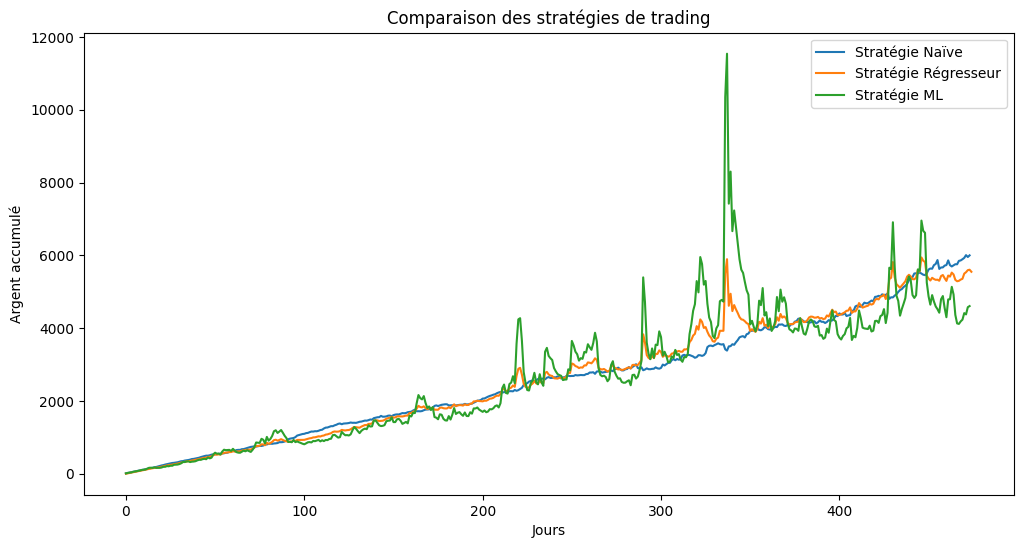

In [ ]:
trading_test(train_dataset,test_dataset,model_classifier=model_classif,num_layers=num_layers,hidden_dim=hidden_dim,value_data = val_indices)